In [1]:
!pip install transformers==4.6.0
import os
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer  # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re  # regular expressions, useful for decoding the output
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=2144de7e356b92dc04b24e6bdb9810bd9c6cfdb6a5bc1134ca1ee7928ef4aa8c
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [2]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
    x1, x2 = t.meshgrid(t.arange(i_start, i_end), t.arange(i_start, i_end))
    X = t.stack((x1.reshape(-1), x2.reshape(-1)), dim=1)
    y = operation(X[:, 0], X[:, 1])
    return X, y

In [3]:
def load_LLM(default="EleutherAI/gpt-neo-2.7B", device='cpu'):
    # tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    # model = GPT2LMHeadModel.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained(default).to(device)
    tokenizer = AutoTokenizer.from_pretrained(default)
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token
    return model, tokenizer

In [4]:
def encode_problems(X, strategy='baseline'):
    output_strings = []
    for xi in X:
        if strategy == 'baseline':
            encode_string = f"{xi[0]}+{xi[1]}="
        elif strategy == 'code':
            encode_string = f"A={xi[0]}, B={xi[1]}, A+B="
        else:
            encode_string = "Unknown strategy"
        output_strings.append(encode_string)
    return output_strings

In [5]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'):
    t0 = time.time()
    output_strings = []

    for prompt in prompts:
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

        with t.no_grad():
           outputs = model.generate(input_ids=input_ids, pad_token_id=tokenizer.eos_token_id)

        output_string = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        output_strings.append(output_string)

    if verbose:
        print("Example tokenization:")
        print(f"Input: {prompts[0]}")
        print(f"Tokenized input: {tokenizer.encode(prompts[0])}")
        print(f"Output: {output_strings[0]}")
        print(f"Tokenized output: {tokenizer.encode(output_strings[0])}")

    print("Time to generate text: ", time.time() - t0)  # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.
    return output_strings


In [6]:
def decode_output(output_strings, strategy='baseline', verbose=True):
    y_hat = []
    for s in output_strings:
        try:
            if strategy == 'baseline':
                num = int(re.split(r'\D+', s)[0])
            else:
                num = int(re.findall(r'\d+', s)[-1])
        except:
            num = np.nan
        y_hat.append(num)
    return y_hat


In [8]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")  
# Use GPU if available
device = t.device('mps') if t.backends.mps.is_available() else device  
# Use Apple's Metal backend if available

X, y = create_dataset(0, 10)
model, tokenizer = load_LLM(default="EleutherAI/gpt-neo-1.3B", device=device)

y_hats = []  # list of lists of predicted answers, y_hat, for each strategy
strategies = ['baseline', 'code']

for strategy in strategies:
    input_strings = encode_problems(X, strategy=strategy)
    # output_strings = generate_text(model, tokenizer, input_strings,batch_size=2, device=device)
    output_strings = generate_text(model, tokenizer, input_strings, device=device)
    output_strings = [out_s[len(in_s):] for in_s, out_s in zip(input_strings, output_strings)]  # Remove the input string from generated answer
    y_hats.append(decode_output(output_strings, strategy=strategy))


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Example tokenization:
Input: 0+0=
Tokenized input: [15, 10, 15, 28]
Output: 0+0=0+0=0+0=0+0=0+0=
Tokenized output: [15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28]
Time to generate text:  1109.3179371356964
Example tokenization:
Input: A=0, B=0, A+B=
Tokenized input: [32, 28, 15, 11, 347, 28, 15, 11, 317, 10, 33, 28]
Output: A=0, B=0, A+B=1, A-B=1,
Tokenized output: [32, 28, 15, 11, 347, 28, 15, 11, 317, 10, 33, 28, 16, 11, 317, 12, 33, 28, 16, 11]
Time to generate text:  607.0889291763306


In [36]:
def analyze_results(X, y, y_hats, strategies):
    for i, (strategy, y_hat) in enumerate(zip(strategies, y_hats)):
        correct = [1 if a == b else 0 for a, b in zip(y_hat, y)]
        accuracy = sum(correct) / len(correct)
        print(f"Accuracy for {strategy}: {accuracy:.2%}")

        X_correct = X[[i for i, c in enumerate(correct) if c == 1], :]
        X_incorrect = X[[i for i, c in enumerate(correct) if c == 0], :]
        
        fig, ax = plt.subplots()
        ax.scatter(X_correct[:, 0], X_correct[:, 1], marker='o', label='Correct')
        ax.scatter(X_incorrect[:, 0], X_incorrect[:, 1], marker='x', label='Incorrect')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(f"Scatter plot of problems (x1+x2) - {strategy}")
        ax.legend()
        plt.show()

        clf = RandomForestClassifier(n_estimators=100, max_depth=5)
        clf.fit(X, correct)
        train_accuracy = clf.score(X, correct)
        print(f"Accuracy on training data: {train_accuracy:.2%}")

        xx, yy = np.meshgrid(np.linspace(-1, 10, 100), np.linspace(-1, 10, 100))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots()
        ax.contourf(xx, yy, Z, alpha=0.75, cmap='viridis')
        ax.scatter(X_correct[:, 0], X_correct[:, 1], marker='o', label='Correct')
        ax.scatter(X_incorrect[:, 0], X_incorrect[:, 1], marker='x', label='Incorrect')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(f"Scatter plot with classifier boundary - {strategy}")
        ax.legend()
        plt.show()


Accuracy for baseline: 9.00%


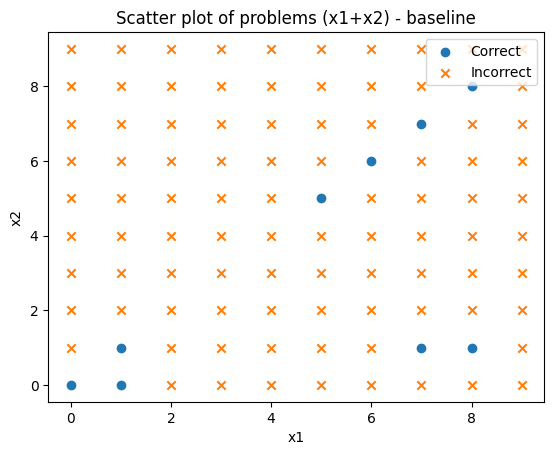

Accuracy on training data: 96.00%


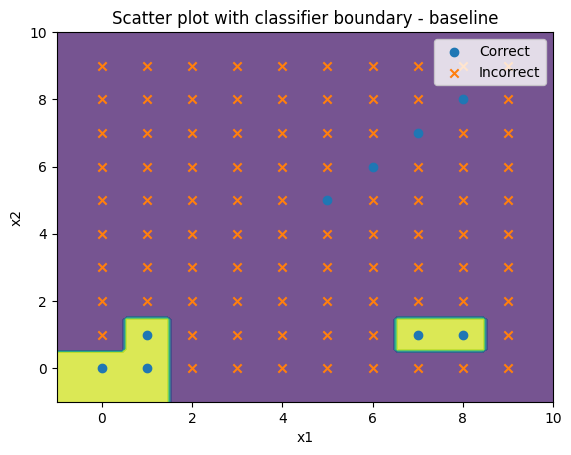

Accuracy for code: 3.00%


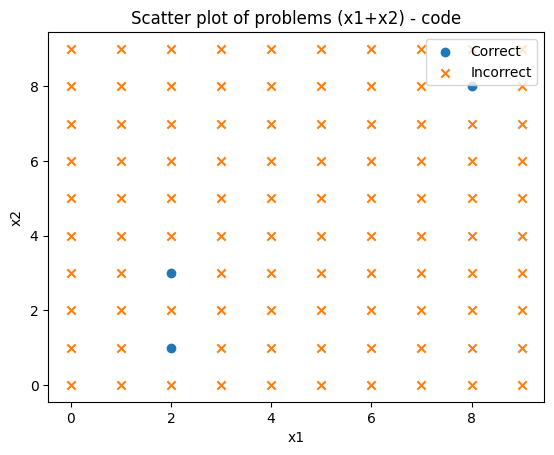

Accuracy on training data: 100.00%


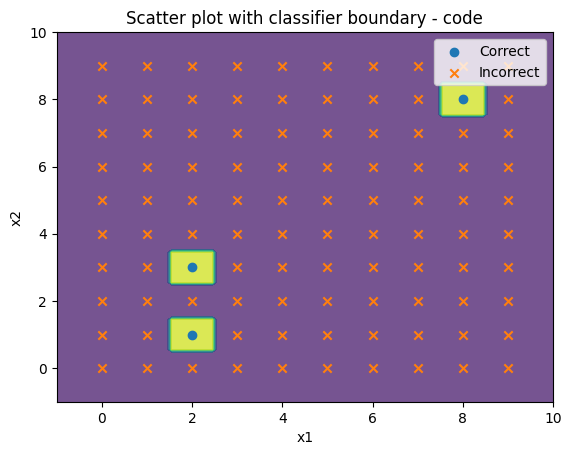

In [37]:
analyze_results(X, y, y_hats, strategies)